Trading Hypothesis: If interest rates rise, the valuations of tech companies will be affected more than the stock market as a whole. 

Why? – We should complete your own historical analysis of market analyst deflation of the valuations of various business sectors based on historical interest rate increases. Tech companies are more interest rate sensitive as a result of the current DCF valuation based on expectations of high future free cash flow growth.


# **How could we benefit from this view?**

The NASDAQ-100 index is highly regarded for the technology sector. On the other hand, the S&P 500 index is recognized as having a broad and diverse composition and representing the entire market. What makes this type of trading possible is that these two indicators, although slightly different, have a high degree of price correlation.

In [1]:
import numpy as np
import pandas as pd 
import datetime as dt
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yfin
from time import time
from scipy.linalg import cholesky
yfin.pdr_override()

[*********************100%***********************]  2 of 2 completed


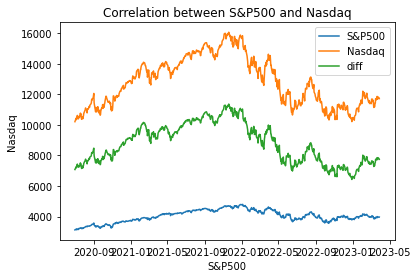

stats
              ^GSPC         ^IXIC          diff
count   689.000000    689.000000    689.000000
mean   4032.333850  12803.572380   8771.238531
std     393.191115   1596.585569   1285.602105
min    3130.010010  10207.629883   6430.070068
25%    3790.929932  11364.410156   7627.660156
50%    4012.320068  12740.790039   8710.459717
75%    4357.859863  14090.219727   9836.639648
max    4796.560059  16057.440430  11359.480469 

last price diff 7744.81005859375


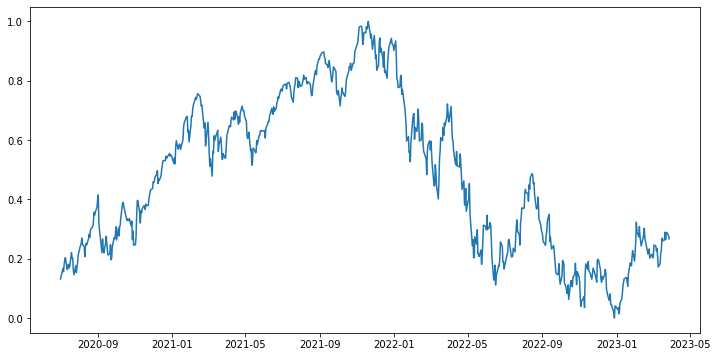

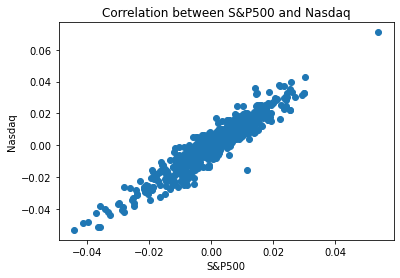

Index Correlation:            ^GSPC     ^IXIC
^GSPC  1.000000  0.941867
^IXIC  0.941867  1.000000
Index Covariance to Volatilty:            ^GSPC     ^IXIC
^GSPC  0.187715  0.210514
^IXIC  0.210514  0.250653
Index Volatility:  ^GSPC    0.187579
^IXIC    0.250471
dtype: float64


In [12]:
def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    log_returns = np.log(stockData) - np.log(stockData.shift(1))
    covMatrix = log_returns.cov()
    corMatrix = log_returns.corr()
    return stockData, log_returns, covMatrix, corMatrix

indices = ['^GSPC', '^IXIC']
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=1000)
prices, log_returns, covMatrix, corMatrix = get_data(indices, startDate, endDate)
prices['diff'] = prices['^IXIC'] - prices['^GSPC']

plt.plot(prices)
plt.title('Correlation between S&P500 and Nasdaq')
plt.xlabel('S&P500')
plt.ylabel('Nasdaq')
plt.legend(['S&P500', 'Nasdaq', 'diff'])
plt.show()

print('stats\n',prices.describe(), '\n\nlast price diff',prices['diff'][-1])

df = prices['diff']
normalized_df=(df-df.mean())/df.std()
# to use min-max normalization:
mm_normalized_df=(df-df.min())/(df.max()-df.min())

# plt.plot(normalized_df)
plt.figure(figsize=(12,6))
plt.plot(mm_normalized_df)
plt.show()

plt.scatter(log_returns['^GSPC'], log_returns['^IXIC'])
plt.title('Correlation between S&P500 and Nasdaq')
plt.xlabel('S&P500')
plt.ylabel('Nasdaq')
plt.show()
print('Index Correlation: ', corMatrix)
print('Index Covariance to Volatilty: ', np.sqrt(covMatrix)*np.sqrt(252))
print('Index Volatility: ', np.std(log_returns)*np.sqrt(252))

# **Trading Opportunities in Equity Index Futures**

To construct this spread between Index Futures, we must first calculate the spread ratio. The spread is defined as the nominal value of one index futures contract divided by the nominal value of another index. In this case, we will divide the nominal value of the NASDAQ-100 futures contract by the nominal value of the S&P 500 futures contract. 

Trade execution example: A portfolio manager (PM) believes the technology sector is more risky than the broader market. He is willing to express this opinion with a risk position equivalent to $10 million, prompting the Prime Minister to take the following actions: PM sells widely E-mini NASDAQ-100/E-mini S&P 500.

In [4]:
# Parameters
SP500 = 4373.94
NASD = 13751.40

emini_SP500_x = 50 # $50 per point
emini_NASD_x = 20 # $20 per point

emini_SP500 = SP500*emini_SP500_x
emini_NASD = NASD*emini_NASD_x

spread_ratio = emini_NASD/emini_SP500

print('Notational Value of E-mini S&P500: ', round(emini_SP500,0))
print('Notational Value of E-mini NASDAQ: ', round(emini_NASD,0))
print('Spread Ratio: ', round(spread_ratio,2))

print('Portfolio Postion: $', 10000000,'\n')

print('Short Postion in E-mini NASDAQ: ', int(10000000/emini_NASD))
print('Long Position in E-mini S&P500: ', int(spread_ratio*10000000/emini_NASD))

Notational Value of E-mini S&P500:  218697.0
Notational Value of E-mini NASDAQ:  275028.0
Spread Ratio:  1.26
Portfolio Postion: $ 10000000 

Short Postion in E-mini NASDAQ:  36
Long Position in E-mini S&P500:  45


# **OTHER OPTION: OTC Spread Options on Indices**

One of the main applications of Monte Carlo simulations is option pricing in terms of multiple random factors. A pricing option whose payout depends on multiple asset prices or with random volatility. Consider a European arbitrage option on the difference between two assets (stock indices) $S_1$ and $S_2$ following the GBM process.

$dS_1 = (r-\delta_1)S_1dt + \sigma_1S_1dz_1$

$dS_2 = (r-\delta_2)S_2dt + \sigma_2S_2dz_2$

In [5]:
# Parameters
SP500 = 4373.94
NASD =     13751.40
div_SP500 = 0.0127
div_NASD = 0.0126
vol_SP500 = 0.143050
vol_NASD = 0.194692
K = 9377 # current difference between index points 
T = 1
r = 0.01828 # 10yr US Treasury Bond
rho = 0.922323 # correlation
N = 1 # discrete time steps
M = 1000 # number of simulations

# **Slow Steps**

In [6]:
# Precompute constants
dt = T/N
S1 = NASD
S2 = SP500
nu1dt = (r - div_NASD - 0.5*vol_NASD**2)*dt
nu2dt = (r - div_SP500 - 0.5*vol_SP500**2)*dt
vol1sdt = vol_NASD*np.sqrt(dt)
vol2sdt = vol_SP500*np.sqrt(dt)
srho = np.sqrt(1-rho**2)

# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
for i in range(M):
    St1 = NASD
    St2 = SP500
    
    for j in range(N):
        dz1 = np.random.normal()
        dz2 = np.random.normal()
        z1 = dz1
        z2 = rho*dz1 + srho*dz2
        St1 = St1*np.exp(nu1dt + vol1sdt*z1)
        St2 = St2*np.exp(nu2dt + vol2sdt*z2)
    
    CT = max(0, K - (St1 - St2))
    
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $782.9 with SE +/- 33.88


# **Fast Solution**

In [7]:
# Precompute constants
N=100
dt = T/N
S1 = NASD
S2 = SP500
nu1dt = (r - div_NASD - 0.5*vol_NASD**2)*dt
nu2dt = (r - div_SP500 - 0.5*vol_SP500**2)*dt
vol1sdt = vol_NASD*np.sqrt(dt)
vol2sdt = vol_SP500*np.sqrt(dt)
srho = np.sqrt(1-rho**2)

# Monte Carlo Method
dz1 = np.random.normal(size=(N, M)) 
dz2 = np.random.normal(size=(N, M)) 
Z1 = dz1
Z2 = rho*dz1 + srho*dz2
delta_St1 = nu1dt + vol1sdt*Z1
delta_St2 = nu2dt + vol2sdt*Z2
ST1 = S1*np.cumprod( np.exp(delta_St1), axis=0)
ST2 = S2*np.cumprod( np.exp(delta_St2), axis=0)
ST1 = np.concatenate( (np.full(shape=(1, M), fill_value=S1), ST1 ) )
ST2 = np.concatenate( (np.full(shape=(1, M), fill_value=S2), ST2 ) )

CT = np.maximum(0, K - (ST1[-1] - ST2[-1]))
C0 = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0)**2) / (M-1) )
SE= sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,3)))

Call value is $851.26 with SE +/- 34.868


# **European Spread Call Option with Stochastic Volatility**

One of the main advantages of Monte Carlo simulation is that option pricing is based on multiple factors, multiple underlying asset prices or stochastic volatility or even interest rate changes. For example pricing a European Spread Call Option between the two stock market indices S1 and S2 follows a more general stochastic process. SDEs will have random volatility as described by the Heston model:

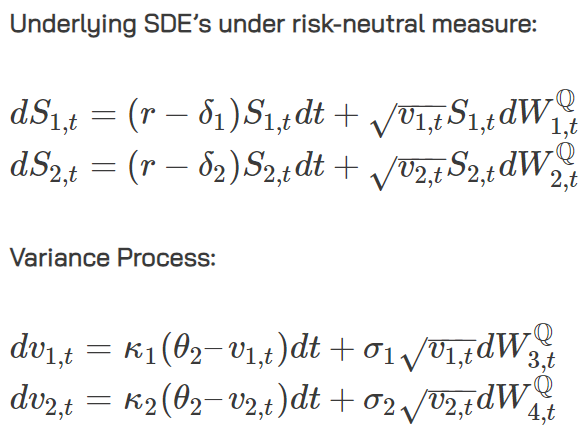

The Monte Carlo procedure is exactly the same for a spread call option except the correlation matrix between Wiener processes is larger, as in we have four correlated normal variates to simulate the four processes.    

Where:

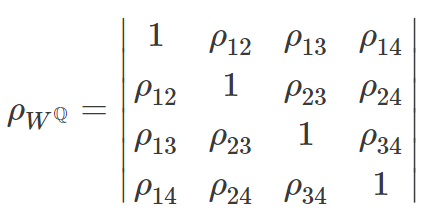

Notation:

– St Equity spot price, financial index

– vt Variance.

– C European call option price.

– K Strike price.

– W1,2 Standard Brownian movements.

– r Interest rate.

– δ discrete dividend payment

– κ Mean reversion rate.

– θ Long run variance.

– v0 Initial variance.

– σ Volatility of variance.

– ρ Correlation parameter.

– t Current date.

– T Maturity date.


# **Example of Nasdaq vs S&P500 Index**

Divergence between the spread of the NASDAQ and S&P500 Indices with stochastic volatility.

In [9]:
# Parameters - as of 1-Mar-22 
SP500 = 4373.94
NASD =     13751.40
div_SP500 = 0.0127
div_NASD = 0.0126
K = 9377 # current difference between index points 
T = 1
r = 0.01828 # 10yr US Treasury Bond Yield

# Heston Model Parameters - made up for the example, 
# we have discussed how to complete this step in a previous video using market option prices
theta1 = 0.02
theta2 = 0.03
kappa1 = 0.1
kappa2 = 0.12
sigma1 = 0.05 
sigma2 = 0.06

# initial variances
vt10 = 0.03
vt20 = 0.03

# Correlation matrix between wiener process under risk-neutral measure
rho = np.array([[1,0.5,0.15,0.02],
                [0.5,1,0.01,0.25],
                [0.15,0.01,1,0.2],
                [0.02,0.25,0.2,1]])

# **Slow Implementation**

In [10]:
# Monte Carlo Specific Parameters
N = 100    # discrete time steps
M = 1000   # number of simulations

# Start Timer
start_time = time()

# Precompute constants
dt = T/N

# log normal prices
lnS1 = np.log(NASD)
lnS2 = np.log(SP500)

# Heston model adjustments for time steps
kappa1dt = kappa1*dt
kappa2dt = kappa2*dt
sigma1sdt = sigma1*np.sqrt(dt)
sigma2sdt = sigma2*np.sqrt(dt)
vt1 = vt10
vt2 = vt20

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)

# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0

# Monte Carlo Method
for i in range(M):
    # for each simulation i in M
    lnSt1 = lnS1
    lnSt2 = lnS2
    
    for j in range(N):
        # for each time step j in N
        
        # Generate correlated Wiener variables
        Z = np.random.normal(0.0, 1.0, size=(4))
        W = Z @ lower_chol
        
        # Simulate variance processes
        vt1 = vt1 + kappa1dt*(theta1 - vt1) + sigma1sdt*np.sqrt(vt1)*W[2]
        vt2 = vt2 + kappa2dt*(theta2 - vt2) + sigma2sdt*np.sqrt(vt2)*W[3]
        
        # Simulate log asset prices
        nu1dt = (r - div_NASD - 0.5*vt1)*dt
        nu2dt = (r - div_SP500 - 0.5*vt2)*dt
        
        lnSt1 = lnSt1 + nu1dt + np.sqrt(vt1*dt)*W[0]
        lnSt2 = lnSt2 + nu2dt + np.sqrt(vt2*dt)*W[1]
        
    St1 = np.exp(lnSt1)
    St2 = np.exp(lnSt2)
    
    CT = max(0, (St1 - St2) - K)
    
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT

# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))
print("Calculation time: {0} sec".format(round(time() - start_time,2))) 

<ipython-input-10-2171c52066f0>:51: RuntimeWarning: invalid value encountered in sqrt
  lnSt1 = lnSt1 + nu1dt + np.sqrt(vt1*dt)*W[0]
<ipython-input-10-2171c52066f0>:44: RuntimeWarning: invalid value encountered in sqrt
  vt1 = vt1 + kappa1dt*(theta1 - vt1) + sigma1sdt*np.sqrt(vt1)*W[2]


Call value is $408.22 with SE +/- 35.39
Calculation time: 3.78 sec


# **Fast Implementation - Vectorizing option pricing**

In [11]:
# Monte Carlo Specific Parameters
N = 100    # discrete time steps
M = 1000   # number of simulations

# Start Timer
start_time = time()

# Precompute constants
dt = T/N

# Heston model adjustments for time steps
kappa1dt = kappa1*dt
kappa2dt = kappa2*dt
sigma1sdt = sigma1*np.sqrt(dt)
sigma2sdt = sigma2*np.sqrt(dt)

# Perform (lower) cholesky decomposition
lower_chol = cholesky(rho, lower=True)

# Generate correlated Wiener variables
Z = np.random.normal(0.0, 1.0, size=(N,M,4))
W = Z @ lower_chol 

# arrays for storing prices and variances
lnSt1 = np.full(shape=(N+1,M), fill_value=np.log(NASD))
lnSt2 = np.full(shape=(N+1,M), fill_value=np.log(SP500))
vt1 = np.full(shape=(N+1,M), fill_value=vt10)
vt2 = np.full(shape=(N+1,M), fill_value=vt20)

for j in range(1,N+1):

    # Simulate variance processes
    vt1[j] = vt1[j-1] + kappa1dt*(theta1 - vt1[j-1]) + sigma1sdt*np.sqrt(vt1[j-1])*W[j-1,:,2]
    vt2[j] = vt2[j-1] + kappa2dt*(theta2 - vt2[j-1]) + sigma2sdt*np.sqrt(vt2[j-1])*W[j-1,:,3]

    # Simulate log asset prices
    nu1dt = (r - div_NASD - 0.5*vt1[j])*dt
    nu2dt = (r - div_SP500 - 0.5*vt2[j])*dt

    lnSt1[j] = lnSt1[j-1] + nu1dt + np.sqrt(vt1[j]*dt)*W[j-1,:,0]
    lnSt2[j] = lnSt2[j-1] + nu2dt + np.sqrt(vt2[j]*dt)*W[j-1,:,1]
        
St1 = np.exp(lnSt1)
St2 = np.exp(lnSt2)

# Compute Expectation and SE
CT = np.maximum(0, (St1[-1] - St2[-1]) - K)
C0 = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0)**2) / (M-1) )
SE= sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))
print("Calculation time: {0} sec".format(round(time() - start_time,2)))

Call value is $943.04 with SE +/- 50.55
Calculation time: 0.07 sec


# **Visualisation**

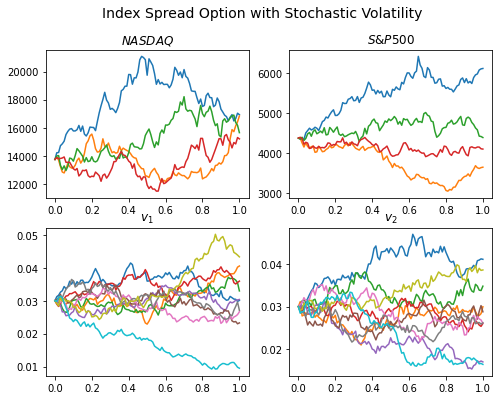

In [12]:
t = np.linspace(0,1,len(St1))
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
ax[0,0].plot(t,St1[:,:4])
ax[0,0].set_title('$NASDAQ$')
ax[0,1].plot(t,St2[:,:4])
ax[0,1].set_title('$S&P500$')
ax[1,0].plot(t,vt1[:,:10])
ax[1,0].set_title('$v_1$')
ax[1,1].plot(t,vt2[:,:10])
ax[1,1].set_title('$v_2$')
fig.suptitle("Index Spread Option with Stochastic Volatility", fontsize=14)
plt.show()